# LSTM for Batch learning 

In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import math, time
import itertools
import datetime
from operator import itemgetter
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
from torch.autograd import Variable
from skorch.callbacks import EarlyStopping
import torch.optim as optim
from skorch import NeuralNetRegressor

import optuna

c:\Users\akilh\OneDrive\Bureau\TELECOM_3A\DataScience-X\DataStreamProcessing\project\StockMarketPrediction\myvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('./data/BTCUSDT.csv', index_col=0)
df.head(5)

,date,open,high,low,close,volume
0,2022-04-29,39742.06,39925.25,38175.00,38596.11,51453.65715
1,2022-04-30,38596.11,38795.38,37578.20,37630.80,35321.18989
2,2022-05-01,37630.80,38675.00,37386.38,38468.35,38812.24104
3,2022-05-02,38468.35,39167.34,38052.00,38525.16,53200.92628
4,2022-05-03,38525.16,38651.51,37517.80,37728.95,40316.45358


In [3]:
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

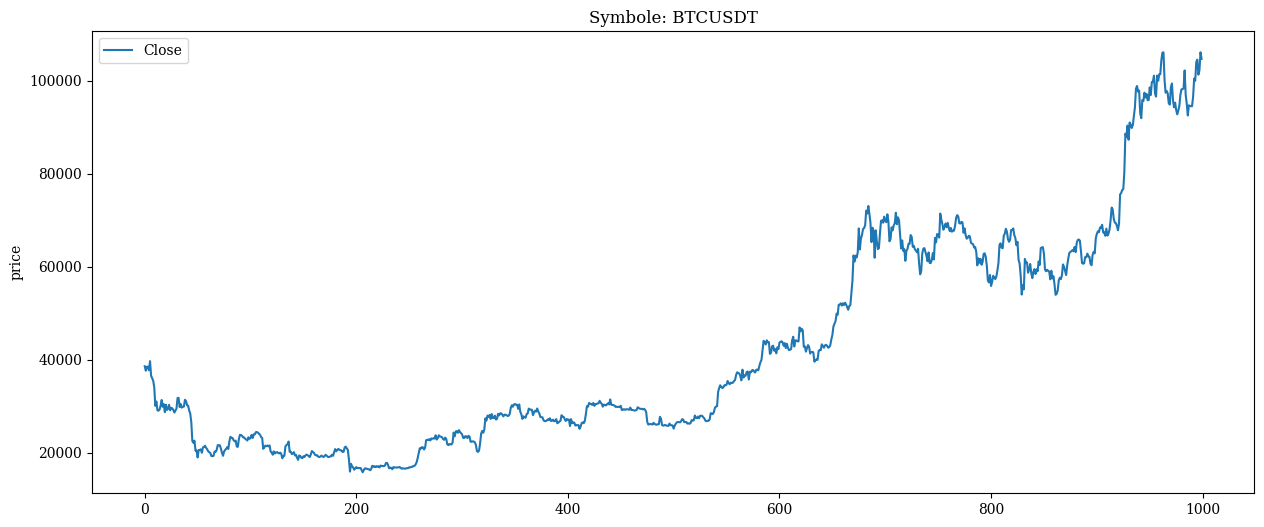

In [23]:
df[['Close']].plot(figsize=(15, 6))
plt.ylabel("price")
plt.title("Symbole: BTCUSDT")
plt.show()

In [5]:
X = df[['Open', 'Low', 'High', 'Volume']]
y = df['Close']

In [6]:
X.head(5)

,Open,Low,High,Volume
0,39742.06,38175.00,39925.25,51453.65715
1,38596.11,37578.20,38795.38,35321.18989
2,37630.80,37386.38,38675.00,38812.24104
3,38468.35,38052.00,39167.34,53200.92628
4,38525.16,37517.80,38651.51,40316.45358


In [7]:
# Splitting data into training and test sets initially
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Define preprocessing for numeric and categorical columns
numeric_features = ['Open', 'Low', 'High', 'Volume']

numeric_transformer = StandardScaler()

# ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Applying transformations separately
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


In [8]:
X_train_transformed

array([[ 0.36264691,  0.31571467,  0.32548125, -0.51118209],
       [ 0.29138873,  0.27770668,  0.25666039, -0.6403613 ],
       [ 0.23136321,  0.26549037,  0.24932799, -0.61240704],
       ...,
       [ 1.63530825,  1.50002545,  1.57858774, -0.4862381 ],
       [ 1.43890132,  1.29081144,  1.3987686 , -0.27180398],
       [ 1.41270813,  1.45206965,  1.45535438, -0.74982153]],
      shape=(800, 4))

In [9]:
# Recreate DataFrames with feature names for interpretability
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=numeric_features, index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=numeric_features, index=X_test.index)

In [10]:
X_train_transformed_df

,Open,Low,High,Volume
0,0.362647,0.315715,0.325481,-0.511182
1,0.291389,0.277707,0.256660,-0.640361
2,0.231363,0.265490,0.249328,-0.612407
3,0.283444,0.307881,0.279317,-0.497191
4,0.286977,0.273860,0.247897,-0.600362
...,...,...,...,...
795,1.802668,1.820704,1.748567,-0.774470
796,1.755127,1.667457,1.687480,-0.665673
797,1.635308,1.500025,1.578588,-0.486238
798,1.438901,1.290811,1.398769,-0.271804


In [11]:
print('x_train.shape = ',X_train_transformed_df.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',X_test_transformed_df.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (800, 4)
y_train.shape =  (800,)
x_test.shape =  (200, 4)
y_test.shape =  (200,)


In [12]:
X_train_tensor = torch.tensor(X_train_transformed_df.values.astype(float)).float().unsqueeze(1)
X_test_tensor = torch.tensor(X_test_transformed_df.values.astype(float)).float().unsqueeze(1)

y_train_tensor = torch.tensor(y_train.values.astype(float)).float()
y_test_tensor = torch.tensor(y_test.values.astype(float)).float()

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state and cell state
        batch_size = x.size(0) # Extract batch size from input
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        out, (h0, c0) = self.lstm(x, (h0.detach(), c0.detach()))

        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :]) # Select the output of the last time step
        
        return out.squeeze()


In [14]:
net = NeuralNetRegressor(
    module=LSTM,
    module__input_size=X_train_transformed_df.shape[1],  # Number of features
    module__hidden_size=32,
    module__num_layers=2,
    module__output_size=1,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    optimizer__lr=0.001,
    batch_size=32,
    max_epochs=100,
    callbacks=[EarlyStopping(patience=5)],
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

net.fit(X_train_tensor, y_train_tensor)

  epoch       train_loss      valid_loss     dur
-------  ---------------  --------------  ------
      1  1612575003.2000  603599430.4000  0.2203
      2  1612565728.0000  603593568.0000  0.2285
      3  1612552264.0000  603585049.6000  0.2312
      4  1612529174.4000  603571859.2000  0.2289
      5  1612490430.4000  603551820.8000  0.2095
      6  1612432406.4000  603522854.4000  0.2185
      7  1612358267.2000  603484268.8000  0.2301
      8  1612275566.4000  603437318.4000  0.2197
      9  1612191320.0000  603384390.4000  0.2117
     10  1612109185.6000  603328473.6000  0.1985
     11  1612031177.6000  603272428.8000  0.1913
     12  1611958040.0000  603218681.6000  0.2013
     13  1611890220.8000  603168556.8000  0.2083
     14  1611827340.8000  603122393.6000  0.1894
     15  1611768822.4000  603079936.0000  0.2000
     16  1611713844.8000  603040588.8000  0.2059
     17  1611661926.4000  603003833.6000  0.2066
     18  1611612342.4000  602969158.4000  0.1844
     19  1611564646.

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=LSTM(
    (lstm): LSTM(4, 32, num_layers=2, batch_first=True)
    (fc): Linear(in_features=32, out_features=1, bias=True)
  ),
)

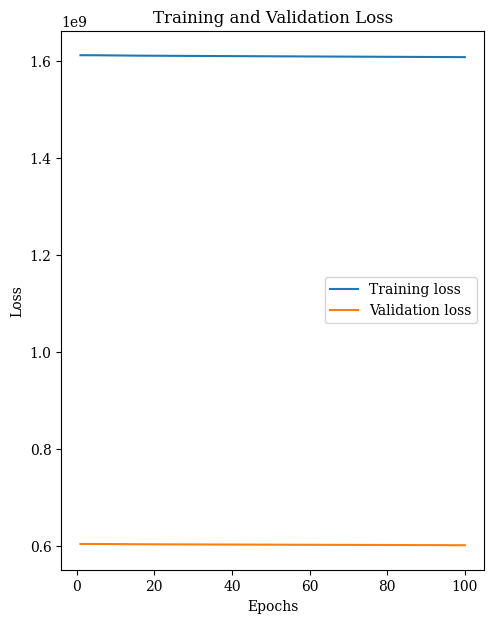

In [15]:
# Access training history
history = net.history_

# Extract training and validation loss
train_loss = history[:, 'train_loss']
valid_loss = history[:, 'valid_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 7))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, valid_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

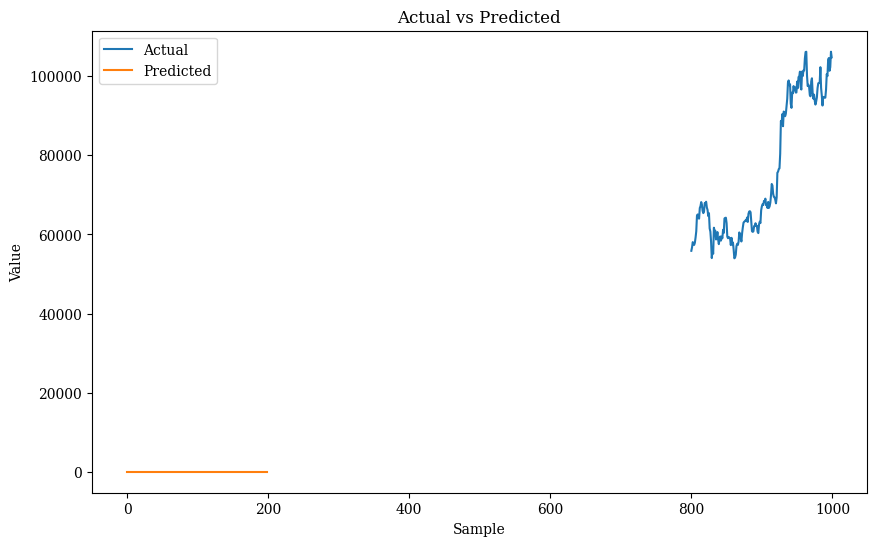

In [16]:
# Obtain predictions on the test set
y_pred = net.predict(X_test_tensor)

# Plot predictions against actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


In [17]:
# Predictions on the training set
y_train_pred = net.predict(X_train_tensor)

# Calculate mean squared error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate mean squared error (MSE) for test set
mse_test = mean_squared_error(y_test, y_pred)

print("Mean Squared Error (MSE) - Training Set:", mse_train)
print("Mean Squared Error (MSE) - Test Set:", mse_test)


Mean Squared Error (MSE) - Training Set: 1407093376.8877866
Mean Squared Error (MSE) - Test Set: 5985030373.888899


### Optuna - Hyperparameter tuning

In [18]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 16, 64)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    lr = trial.suggest_float('lr', 1e-5, 1e-2)
    
    # Construct the LSTM model with suggested hyperparameters
    class LSTM(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, output_size):
            super(LSTM, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)
        
        def forward(self, x):
            batch_size = x.size(0)
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
            
            out, _ = self.lstm(x, (h0, c0))
            out, (h0, c0) = self.lstm(x, (h0.detach(), c0.detach()))
            
            out = self.fc(out[:, -1, :])
            
            return out
    
    # Construct the NeuralNetRegressor with suggested hyperparameters
    net = NeuralNetRegressor(
        module=LSTM,
        module__input_size=X_train_transformed_df.shape[1],
        module__hidden_size=hidden_size,
        module__num_layers=num_layers,
        module__output_size=1,
        criterion=nn.MSELoss,
        optimizer=optim.Adam,
        optimizer__lr=lr,
        batch_size=32,
        max_epochs=100,
        verbose=0,
        callbacks=[EarlyStopping(patience=5)],
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    
    # Train the model
    net.fit(X_train_tensor, y_train_tensor)
    
    # Return the validation loss for Optuna to minimize
    return net.history[-1]['valid_loss']


# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Run Optuna optimization
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2025-01-22 23:13:53,128] A new study created in memory with name: no-name-1c57a482-51cb-43d5-9551-810adf0089f1
c:\Users\akilh\OneDrive\Bureau\TELECOM_3A\DataScience-X\DataStreamProcessing\project\StockMarketPrediction\myvenv\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-01-22 23:14:16,739] Trial 0 finished with value: 596709120.0 and parameters: {'hidden_size': 17, 'num_layers': 3, 'lr': 0.0054257018064485085}. Best is trial 0 with value: 596709120.0.
[I 2025-01-22 23:14:17,405] Trial 1 finished with value: 603571212.8 and parameters: {'hidden_size': 16, 'num_layers': 1, 'lr': 0.001720131010565752}. Best is trial 0 with value: 596709120.0.
[I 2025-01-22 23:14:35,053] Trial 2 finished with value: 5812448

Best Hyperparameters: {'hidden_size': 57, 'num_layers': 2, 'lr': 0.008725837377673568}


In [19]:
print("Best trial:")
trial = study.best_trial

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


Best trial:
  Params: 
    hidden_size: 57
    num_layers: 2
    lr: 0.008725837377673568


  epoch       train_loss      valid_loss     dur
-------  ---------------  --------------  ------
      1  1612517590.4000  603344038.4000  0.2990
      2  1611712923.2000  602724563.2000  1.3536
      3  1610809745.6000  602238656.0000  0.1899
      4  1610107433.6000  601793696.0000  0.2005
      5  1609462142.4000  601379846.4000  0.1911
      6  1608851956.8000  600984492.8000  0.2009
      7  1608263193.6000  600600876.8000  0.2052
      8  1607688689.6000  600225254.4000  0.2000
      9  1607124112.0000  599855468.8000  0.2000
     10  1606567129.6000  599490169.6000  0.2200
     11  1606015828.8000  599128345.6000  0.2100
     12  1605469363.2000  598769414.4000  0.2168
     13  1604926624.0000  598412838.4000  0.1978
     14  1604387097.6000  598058265.6000  0.1848
     15  1603850308.8000  597705420.8000  0.1984
     16  1603315886.4000  597354131.2000  0.1712
     17  1602783526.4000  597004076.8000  0.1800
     18  1602252929.6000  596655244.8000  0.1732
     19  1601723979.

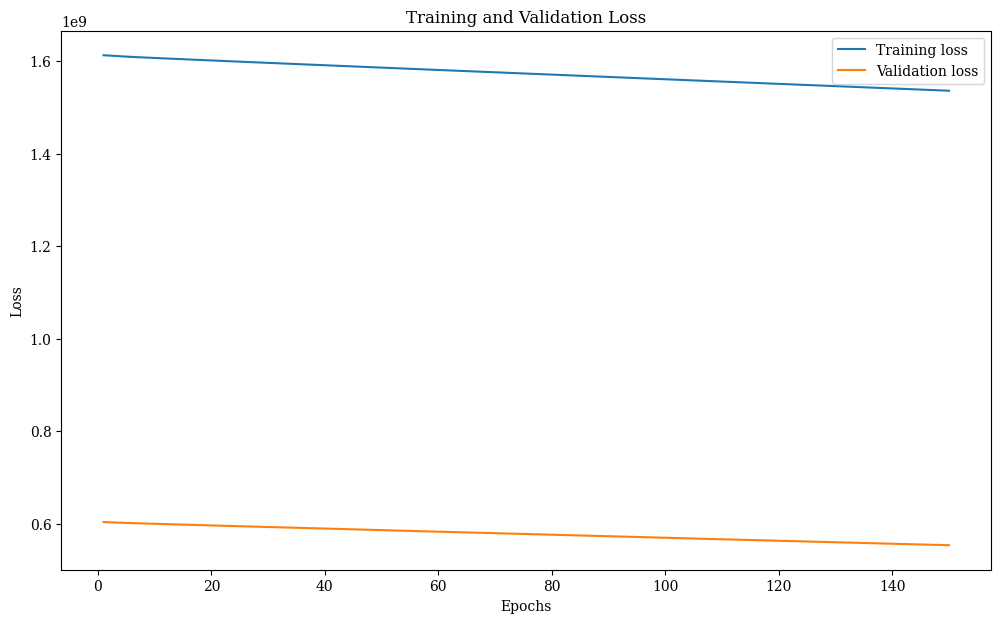

In [20]:
# Get the best hyperparameters
best_params = study.best_params

# Construct the LSTM model with the best hyperparameters
best_model = NeuralNetRegressor(
    module=LSTM,
    module__input_size=X_train_transformed_df.shape[1],
    module__hidden_size=best_params['hidden_size'],
    module__num_layers=best_params['num_layers'],
    module__output_size=1,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    optimizer__lr=best_params['lr'],
    batch_size=32,
    max_epochs=150,
    callbacks=[EarlyStopping(patience=5)],
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Fit the best model with the entire training dataset
best_model.fit(X_train_tensor, y_train_tensor)

# Plot training and validation loss
history = best_model.history
train_loss = history[:, 'train_loss']
valid_loss = history[:, 'valid_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 7))

plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, valid_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


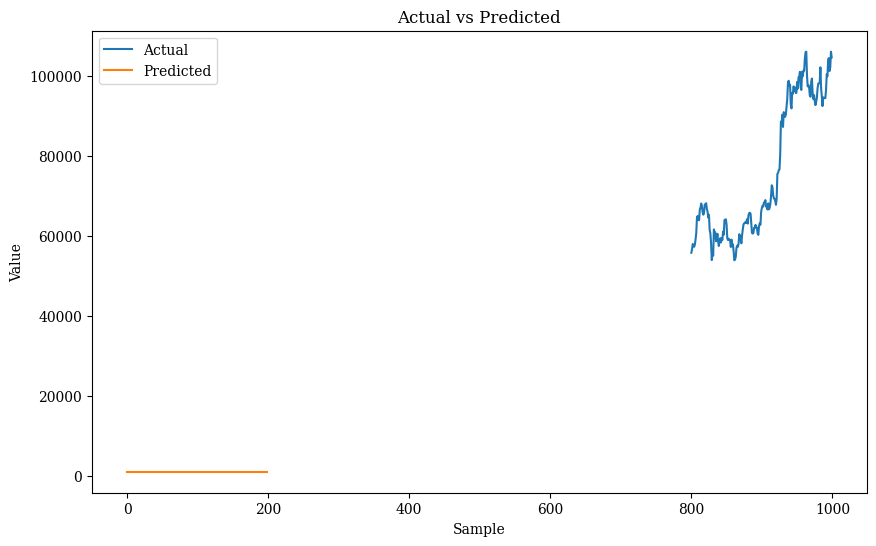

In [21]:
# Obtain predictions on the test set using the best model found by Optuna
y_pred = best_model.predict(X_test_tensor)

# Plot predictions against actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


In [22]:
# Predictions on the training set
y_train_pred = best_model.predict(X_train_tensor)

# Calculate mean squared error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate mean squared error (MSE) for test set
mse_test = mean_squared_error(y_test, y_pred)

print("Mean Squared Error (MSE) - Training Set:", mse_train)
print("Mean Squared Error (MSE) - Test Set:", mse_test)


Mean Squared Error (MSE) - Training Set: 1339083046.1315665
Mean Squared Error (MSE) - Test Set: 5832251913.382119
